Import relevant libraries and modules

In [2]:
!pip install -Uqq fastbook
!pip install voila
!jupyter serverextension enable --sys prefix voila

import fastbook
fastbook.setup_book()

     |████████████████████████████████| 460kB 9.2MB/s 
ERROR: voila 0.2.6 has requirement nbconvert<7,>=6.0.0, but you'll have nbconvert 5.6.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/13/2f/acbe7006548f3914456ee47f97a2033b1b2f3daf921b12ac94105d87c163/nbconvert-6.0.7-py3-none-any.whl
ERROR: nbdev 1.1.11 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
usage: jupyter-serverextension [-h]
                               [--config ENABLESERVEREXTENSIONAPP.CONFIG_FILE]
                               [--log-level ENABLESERVEREXTENSIO

In [3]:
from fastbook import *
from fastai.vision.widgets import *

Link the microsoft azure key to the programme

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '8915317607b741b9ab3336622b1d9415')

Define breeds and collate images


In [5]:
breeds = 'Collie','Beagel','Labrador','Husky','Golden Retriever','Malmute','Poodle','German Shepard', 'Bulldog', 'Dachshund','Rottweiler'
path = Path('dogs')
breeds

('Collie',
 'Beagel',
 'Labrador',
 'Husky',
 'Golden Retriever',
 'Malmute',
 'Poodle',
 'German Shepard',
 'Bulldog',
 'Dachshund',
 'Rottweiler')

In [6]:
if not path.exists():
  path.mkdir()
  for o in breeds:
    print(o)
    dest = (path/o)
    dest.mkdir(exist_ok = True)
    results = search_images_bing(key, f'{o} dog')
    download_images(dest, urls = results.attrgot('contentUrl'))
    

Collie
Beagel
Labrador
Husky
Golden Retriever
Malmute
Poodle
German Shepard
Bulldog
Dachshund
Rottweiler


In [7]:
path.ls
fns = get_image_files(path)
fns

(#1612) [Path('dogs/Husky/00000081.jpg'),Path('dogs/Husky/00000142.jpg'),Path('dogs/Husky/00000047.jpg'),Path('dogs/Husky/00000039.jpg'),Path('dogs/Husky/00000013.jpg'),Path('dogs/Husky/00000088.jpg'),Path('dogs/Husky/00000086.jpg'),Path('dogs/Husky/00000148.jpg'),Path('dogs/Husky/00000101.JPG'),Path('dogs/Husky/00000016.jpg')...]

Identify and remove corrupt files

In [8]:
failed = verify_images(fns)
failed
failed.map(Path.unlink);

Define images as a data block, defining test and validation sets 

In [9]:
dogs = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128))


Define learner and train model

In [10]:
dogs = dogs.new(item_tfms = RandomResizedCrop(224,min_scale = 0.5),
       batch_tfms = aug_transforms())
dls = dogs.dataloaders(path)

learn = cnn_learner(dls,resnet34,metrics = error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Plot a confusion matrix and display the ten top loss images


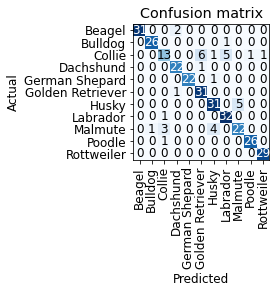

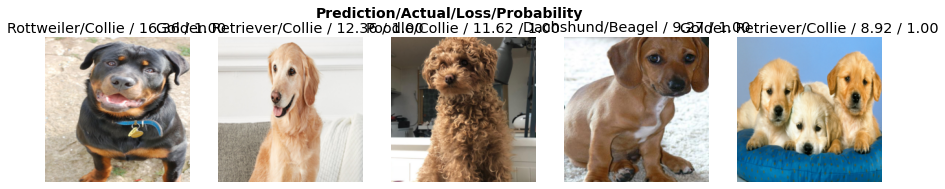

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

Clean data

In [12]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [14]:
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()
for idx,cat in cleaner.change():
  shutil.move(str(cleaner.fns[idx]),path/cat)

FileNotFoundError: ignored

Export

In [15]:
learn.export()

App

In [17]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [18]:
learn_inf = load_learner(path/'export.pkl')
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description = 'classify')

In [19]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl:
    display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)
VBox([widgets.Label('Select your image!'),out_pl,lbl_pred,btn_upload,btn_run])